### **Intro**
We're going to start off by doing some data preprocessing for an emotion classifier model that takes a piece of audio data and labels it.

In [ ]:
# Libraries to install
!python -m pip install librosa
!python -m pip install matplotlib==3.3.4
!python -m pip install datasets[audio]

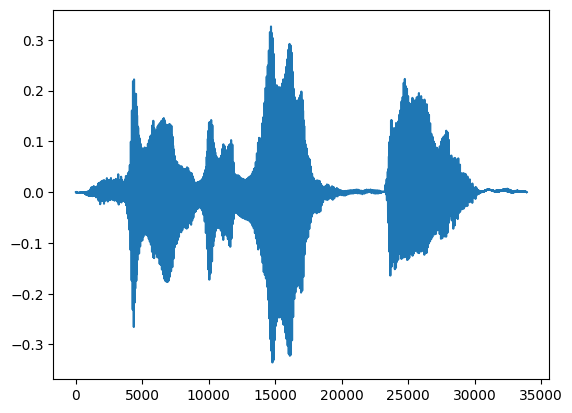

Length of the audio: 1.54 seconds
Number of samples: 37574
Sampling rate: 24414 Hz
Length of the audio: 1.62 seconds
Number of samples: 39468
Sampling rate: 24414 Hz
Length of the audio: 1.54 seconds
Number of samples: 37647
Sampling rate: 24414 Hz
Length of the audio: 1.61 seconds
Number of samples: 39230
Sampling rate: 24414 Hz
Length of the audio: 1.40 seconds
Number of samples: 34062
Sampling rate: 24414 Hz
Length of the audio: 1.55 seconds
Number of samples: 37748
Sampling rate: 24414 Hz
Length of the audio: 1.43 seconds
Number of samples: 34927
Sampling rate: 24414 Hz
Length of the audio: 1.33 seconds
Number of samples: 32387
Sampling rate: 24414 Hz
Length of the audio: 1.67 seconds
Number of samples: 40660
Sampling rate: 24414 Hz
Length of the audio: 1.53 seconds
Number of samples: 37355
Sampling rate: 24414 Hz
Length of the audio: 1.43 seconds
Number of samples: 35005
Sampling rate: 24414 Hz
Length of the audio: 1.69 seconds
Number of samples: 41177
Sampling rate: 24414 Hz
Leng

In [13]:
import os
import librosa
import matplotlib.pyplot as plt
import librosa.display as display

FILE_NAME = "D:\school\MAIS 202\Project\emotion-classifier\data\TESS\OAF_angry\OAF_back_angry.wav"

# Let's analyze some of our audio files
array, sampling_rate = librosa.load(FILE_NAME)
plt.plot(array)
plt.show()

audio_folder_name = "D:\school\MAIS 202\Project\emotion-classifier\data\TESS\OAF_angry"
audio_files = os.listdir(audio_folder_name)

for file_name in audio_files:
    file_path = os.path.join(audio_folder_name, file_name)
    array, sampling_rate = librosa.load(file_path, sr=None)
    print('Length of the audio: {:.2f} seconds'.format(len(array) / sampling_rate))
    print('Number of samples: {}'.format(len(array)))
    print('Sampling rate: {} Hz'.format(sampling_rate))